In [2]:
import scipy
import numpy as np
from fitters import *
from tools import *
from plots import *
from projectors import *
set_seaborn({'figure.figsize': (10,7)})
%load_ext autoreload
%autoreload 2


In [3]:
def get_data(Ydataset, factor, Xdataset='PHOTO'):
    resX, stim = read_lmc(Xdataset)
    resY, stim = read_lmc(Ydataset)
    X = preprocess(resX, factor=factor, method='mean')
    Y = preprocess(resY, factor=factor, method='mean')

    return X, Y


In [252]:
dt_ms = 2.0
lag_ms = 25
factor, dim = convert_dtms_windowms_to_factor_dim(dt_ms, lag_ms)
X_series, Y_series = get_data('LMC-BG1', factor)
time = np.linspace(0, 1, len(X_series))

N = len(X_series)
window = int(dim * 3)
print(f'dim: {dim}, window: {window}')
residues = []
slices = []
for i in range(window, N, 1):


    sl = slice(i-window, i)
    Xhan = build_hankel(X_series[sl], dim)
    X0w = Xhan[:, :-1]
    Xpw = Xhan[:, 1:]

    Xp1 = Xpw[-1]
    X01 = np.vstack((X0w, np.ones(X0w.shape[1])))

    a, res, _, _ = scipy.linalg.lstsq(X01.T, Xp1)
    residues.append(np.mean(res))
    slices.append(sl)

slices = np.array(slices)


dim: 12, window: 36


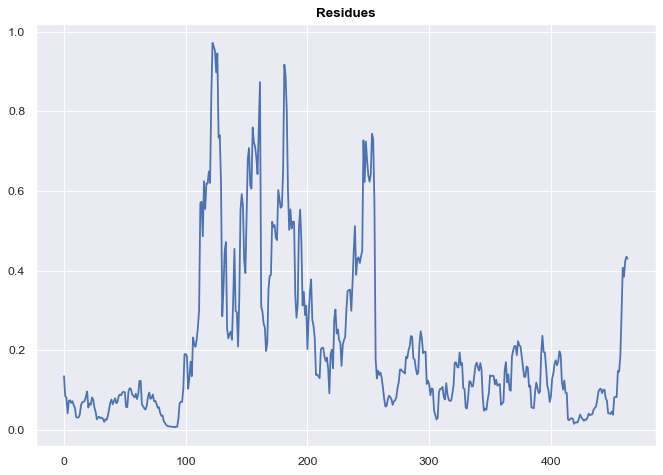

In [253]:
plt.plot(residues, label=f'window={window}');
plt.title('Residues')
plt.show()




In [254]:
ress = np.array(residues).copy()
regions = []
y_regions = []
num_regions = 3
sort_i = np.argsort(ress)
res_sorted= ress[sort_i]
slices_sorted = slices[sort_i]
backset = 5
for i in range(num_regions):
    sl = slices_sorted[i]
    xyr = (time[sl], X_series[sl], res_sorted[i])
    y_regions.append(Y_series[sl])
    regions.append(xyr)


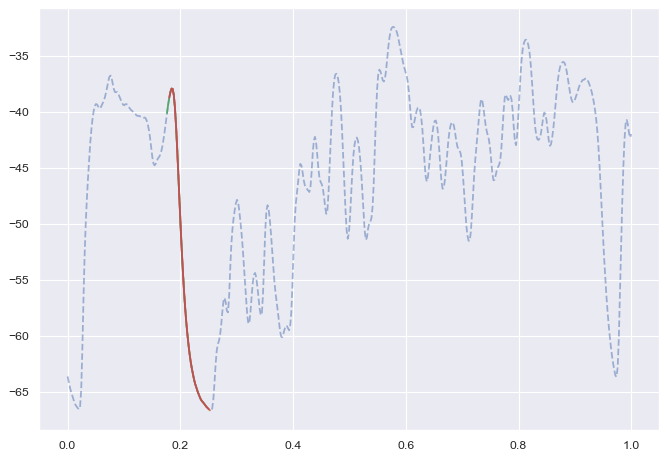

In [255]:
plt.plot(time, X_series, '--', alpha=0.5)
[plt.plot(x,y, label=f'R={r}') for (x,y,r) in regions]
plt.show()

# plt.plot(time, Y_series, '--', alpha=0.5)
# [plt.plot(x,y, label=f'R={r}') for y in y_regions]
# plt.show()

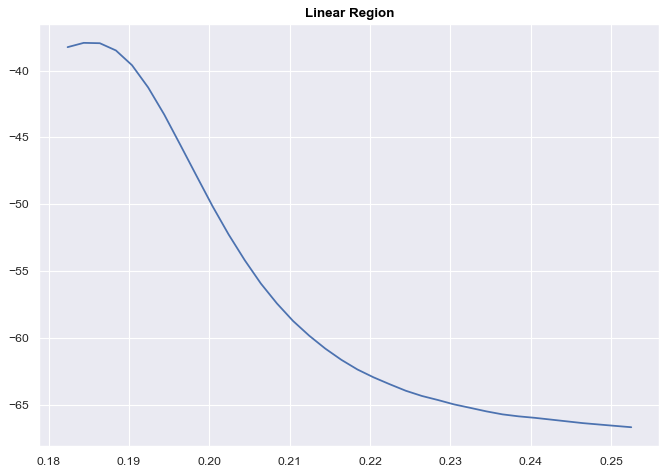

(24,) (36,)


/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


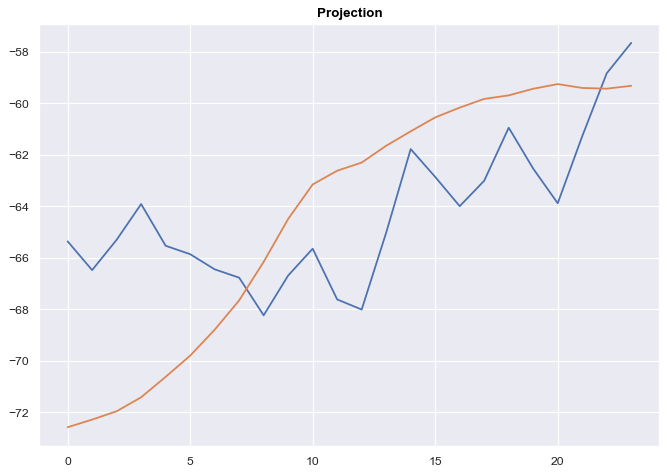

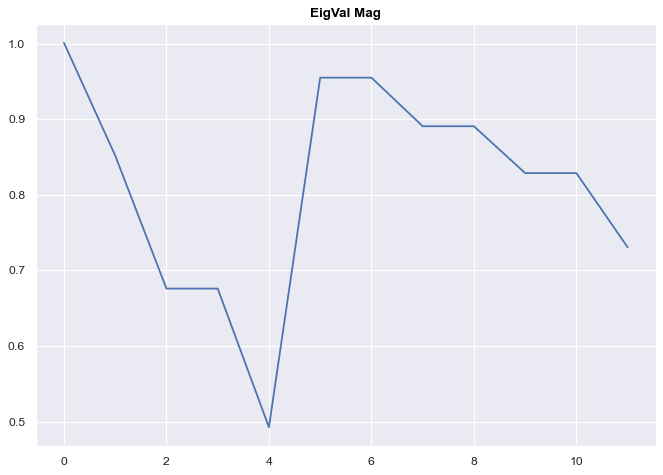

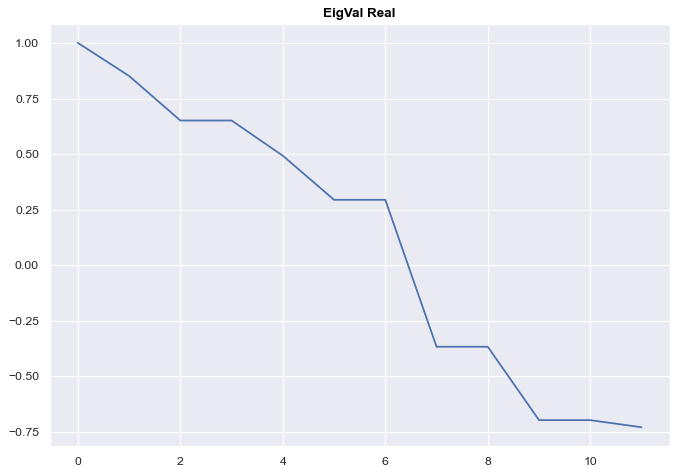

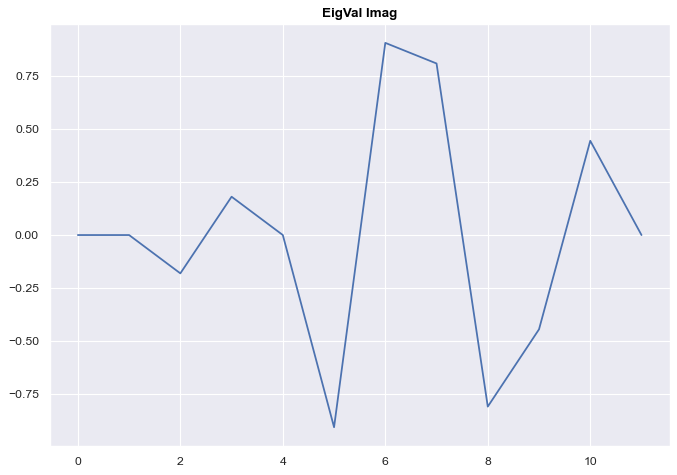

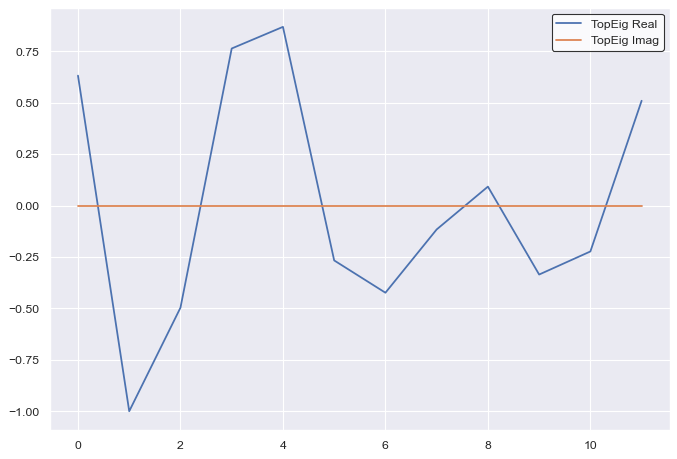

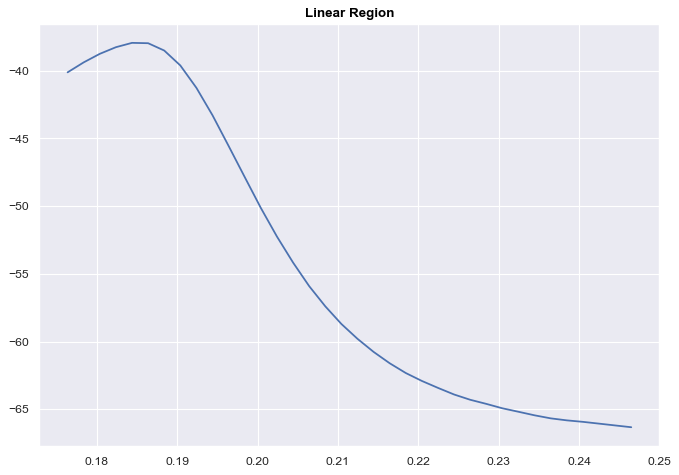

(24,) (36,)


/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


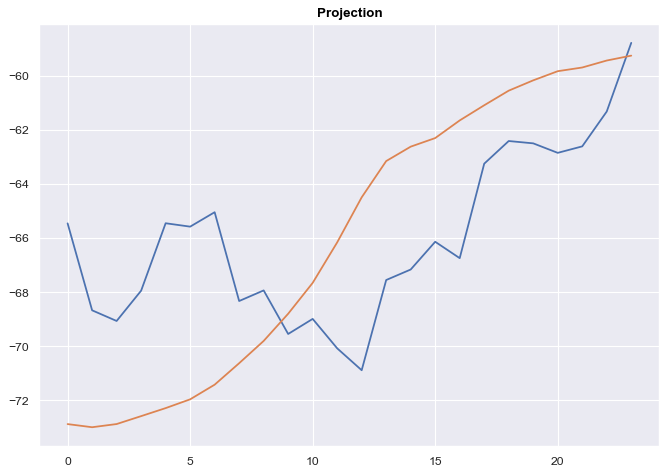

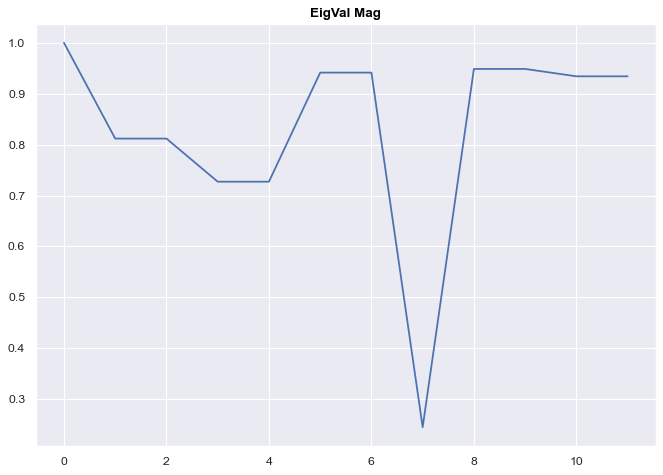

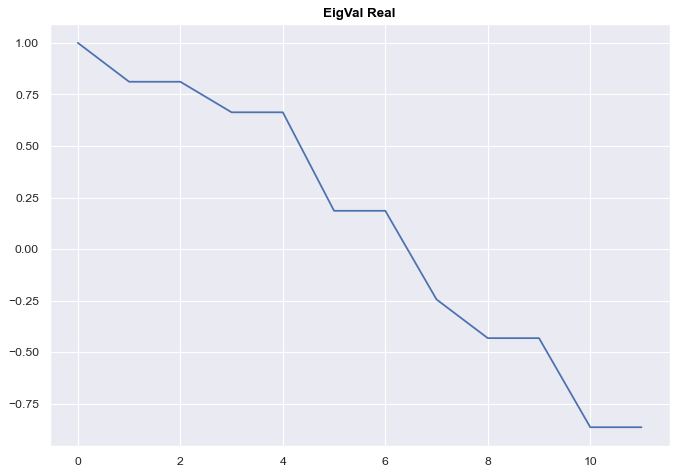

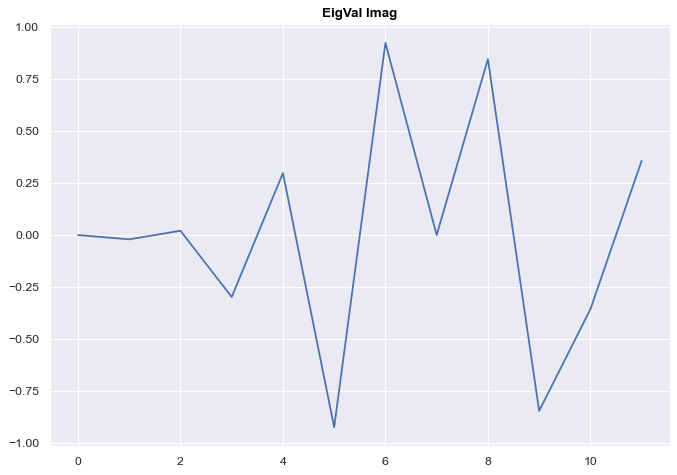

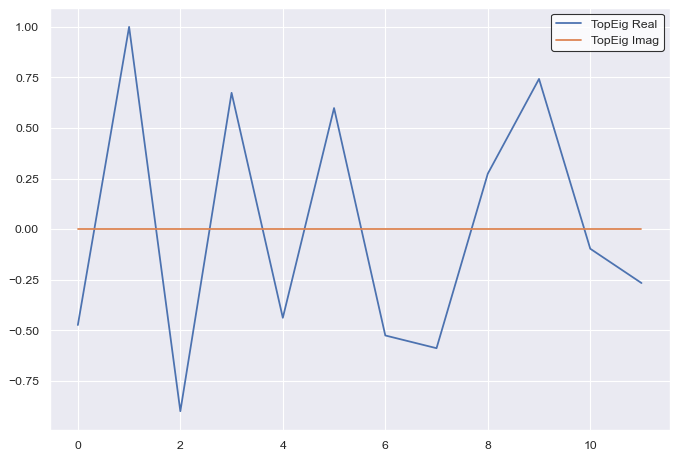

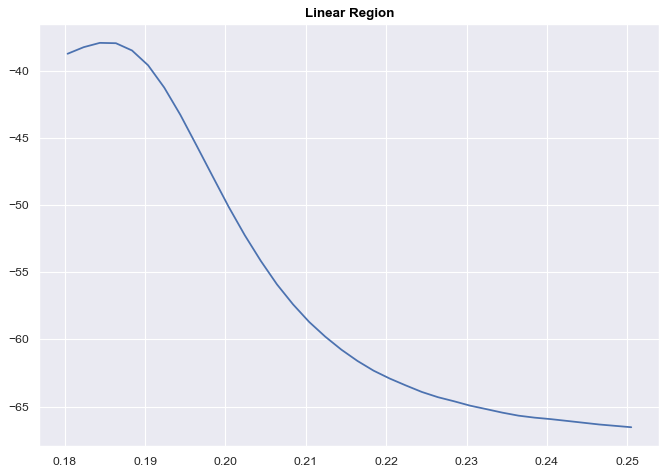

(24,) (36,)


/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


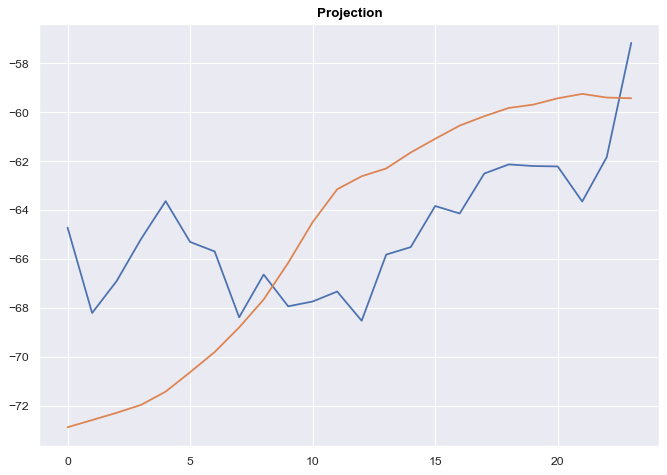

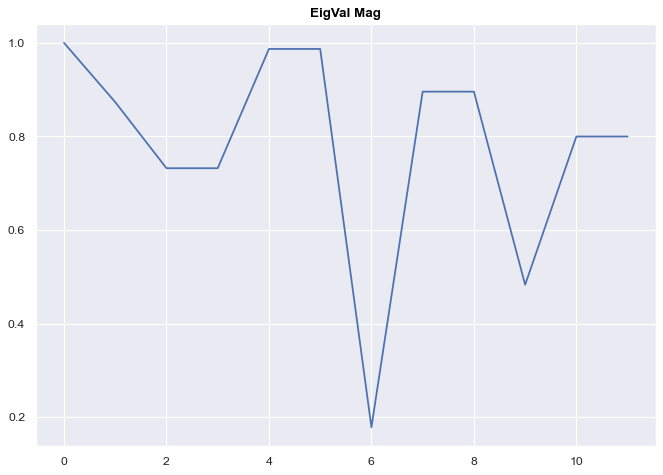

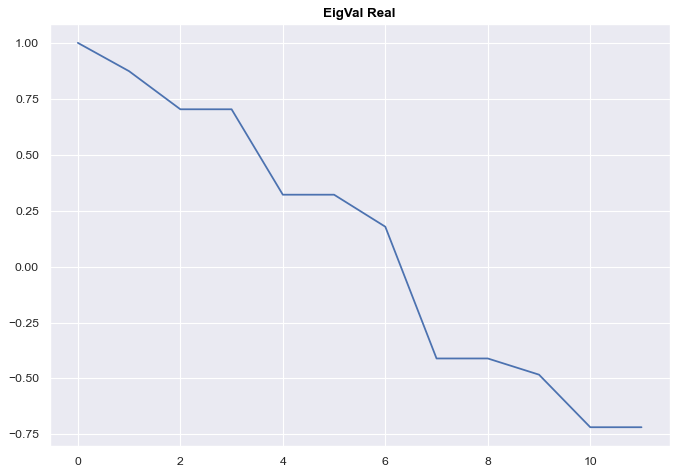

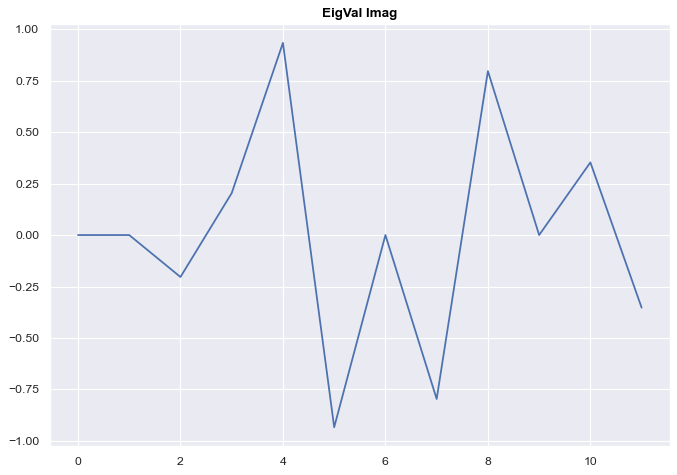

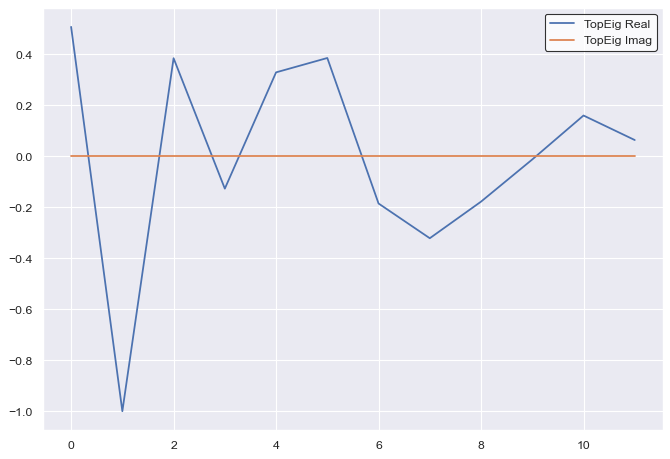

In [256]:


for r_i in range(len(regions)):
    (t, R_series, res) = regions[r_i]
    Y_series = y_regions[r_i]
    plt.plot(t, R_series)
    plt.title('Linear Region')
    plt.show()

    Xhan = build_hankel(R_series, dim)
    X0 = Xhan[:, :-1]
    Xp = Xhan[:, 1:]
    X0Xp = X0 @ Xp.T  # / X0.shape[1]
    X0X0 = X0 @ X0.T  # / X0.shape[1]

    # solve eigenvalue problem
    w, vl = scipy.linalg.eig(X0Xp, X0X0, left=True, right=False)

    sortorder = np.argsort(w.real)
    thetas = vl[:, sortorder][:, ::-1]
    w = w[sortorder][::-1]
    theta = thetas[:, 0]

    P_series = theta @ Xhan

    print(P_series.shape, Y_series.shape)
    Y_series = Y_series[:(window-dim)]
    P_series = solve_scale_shift(P_series, Y_series)
    plt.plot(P_series)
    plt.plot(Y_series)
    plt.title('Projection')
    plt.show()

    plt.plot(abs(w))
    plt.title('EigVal Mag')
    plt.show()
    plt.plot(w.real)
    plt.title('EigVal Real')
    plt.show()
    plt.plot(w.imag)
    plt.title('EigVal Imag')
    plt.show()
    plt.plot(theta.real, label='TopEig Real')
    plt.plot(theta.imag, label='TopEig Imag')
    plt.legend()
    plt.show()


15 30 500


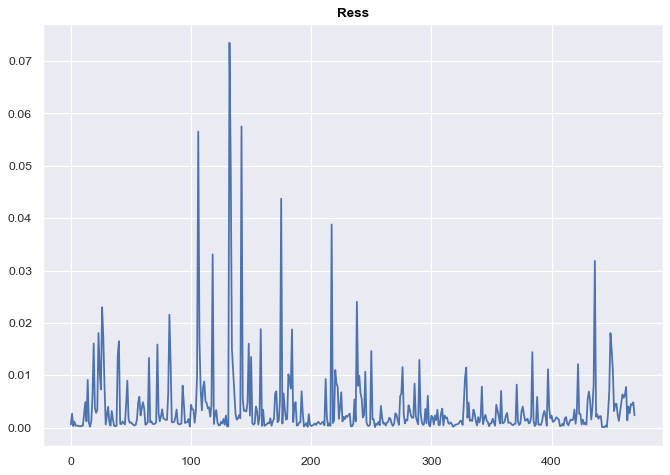

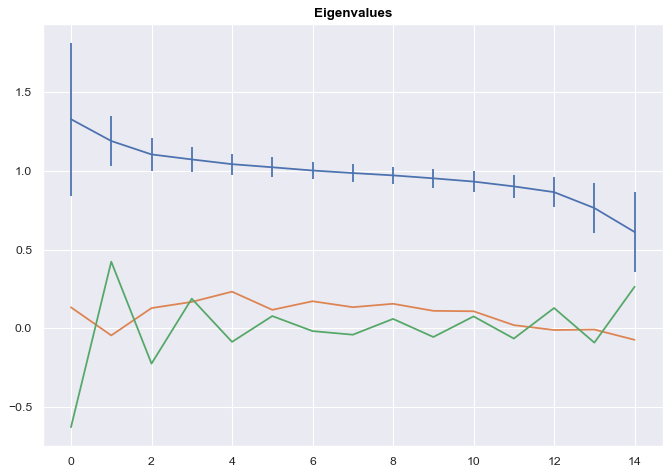

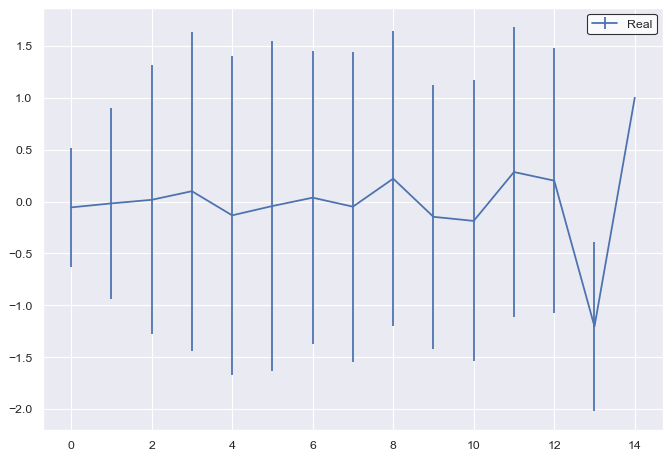

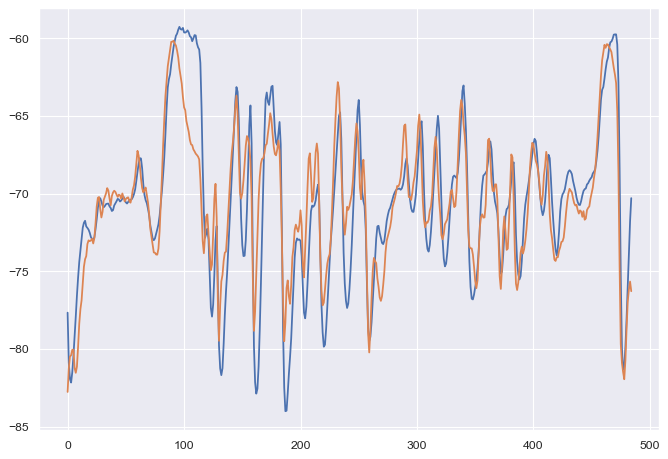

ERR 7.373989882914237


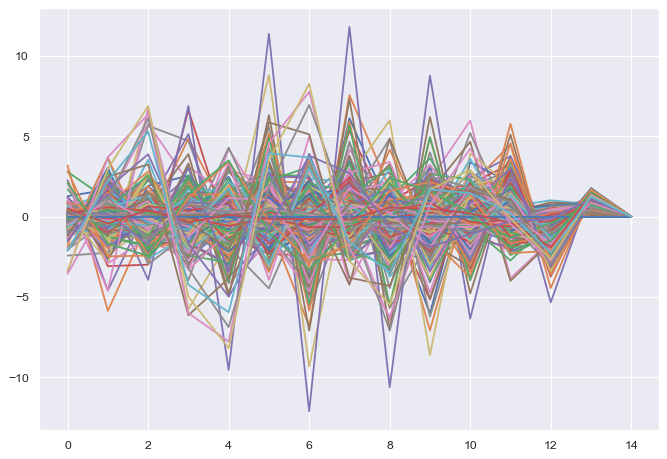

In [45]:
dt_ms = 2.0
lag_ms = 30
factor, dim = convert_dtms_windowms_to_factor_dim(dt_ms, lag_ms)
X_series, Y_series = get_data('LMC-BG1', factor)
Xhan = build_hankel(X_series, dim)
X0 = Xhan[:, :-1]
Xp = Xhan[:, 1:]

N = len(X_series)
window = int(dim * 2)
beta = 0.00001
thetas, ws, ress = [], [], []
print(dim, window, len(X_series))
for i in range(window, N, 1):

    sl = slice(i-window, i)
    Xhan = build_hankel(X_series[sl], dim)
    X0w = Xhan[:, :-1]
    Xpw = Xhan[:, 1:]

    Xp1 = Xpw[-1]
    X01 = np.vstack((X0w, np.ones(X0w.shape[1])))
    reg_dim = dim + 1

    # matrix for regularization
    lam = beta * np.eye(reg_dim)

    a = (Xp1 @ X01.T) @ np.linalg.inv((X01 @ X01.T) + lam)
    #a = scipy.linalg.lstsq(X01.T, Xp1)[0]
    a, c = a[:-1], a[-1:]
    A = np.eye(dim, k=1)
    A[-1] = a
    w, vl = scipy.linalg.eig(A, left=True, right=False)

    c_col = np.zeros((A.shape[1],1)) 
    c_col[-1] =c
    A = np.concatenate((A, c_col), axis=1)
    res = np.linalg.norm(Xpw-(A @ X01))

    sortorder = np.argsort(np.abs(w))
    w = w[sortorder][::-1]
    theta = vl[:, sortorder][:, -1]
    theta /= theta[-1]

    weight = res
    ress.append(res)
    thetas.append(theta)
    ws.append(w)

ws = np.array(ws)
thetas = np.array(thetas)
ress = np.array(ress)
# ress01 = 1-normalize_01(ress)
# thetas = np.multiply(thetas, ress01[:, np.newaxis])
# ws = np.multiply(ws, ress01[:, np.newaxis])
# thetas[ress > 0.001] = np.zeros_like(thetas[0])
plt.plot(ress)
plt.title('Ress')
plt.show()

d = np.arange(0, len(ws[0]))
plt.errorbar(d, np.mean(np.abs(ws), axis=0), np.std(np.abs(ws), axis=0))
plt.plot(np.mean(ws.real, axis=0))
plt.plot(np.mean(ws.imag, axis=0))
plt.title('Eigenvalues')
plt.show()


theta = np.mean(thetas, axis=0)
d = np.arange(0, len(theta))
t_std_real = np.std(thetas.real, axis=0)
t_std_imag = np.std(thetas.imag, axis=0)

plt.errorbar(d, theta.real, t_std_real, label='Real')
# plt.errorbar(d, theta.imag, t_std_imag, label='Imag')
plt.legend()
plt.show()

Xhan = build_hankel(X_series, dim)
P_series = theta.real @ Xhan
Y_series = Y_series[dim:]
P_series = solve_scale_shift(P_series, Y_series)
plt.plot(Y_series)
plt.plot(P_series)
plt.show()
print('ERR', mean_square_error(P_series, Y_series))



[plt.plot(t.imag) for t in thetas]
plt.show()